## Notebook to compare results from the various differential expression methods we used in the ADRD Brain Aging (phase 1) project

Pseudo-replication and zero-inflation are a problem in single-cell data

[Zimmerman KD, Espeland MA, Langefeld CD. A practical solution to pseudoreplication bias in single-cell studies. Nat Commun 2021;12:738.](https://pubmed.ncbi.nlm.nih.gov/33531494/)

we used these methods and are using glmmTMB as gold standard for now
- GLMMTMB
- GLMM (with and without zeros)
- GLM Tweedie (pseudo-bulk)
- diffxpy (t-test)
- Pegasus de_analysis
- Scanpy rank_genes_groups
- scvi-tools differential_expression
- M3Drop selection as input to both scvi and Scanpy

In [1]:
!date

Thu Jan 18 12:18:52 EST 2024


#### import libraries

In [2]:
from pandas import read_csv, concat
from numpy import where, inf
from seaborn import lmplot
from upsetplot import UpSet, from_contents
from upsetplot import plot as upset_plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from statsmodels.formula.api import ols, gls
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from math import sqrt

#### set notebook variables

In [3]:
# parameters
cohort = 'aging'

# directories for initial setup
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase1'
results_dir = f'{wrk_dir}/results'

# in files
result_files = {'glmmtmb': f'{results_dir}/{cohort}.glmmtmb_age_diffs.csv',
                'glmm_nz': f'{results_dir}/{cohort}.glmm_nz_age_diffs.csv',
                'glmm_zi': f'{results_dir}/{cohort}.glmm_zi_age_diffs.csv',
                'glm_pb': f'{results_dir}/{cohort}.glm_pb_age_diffs.csv',
                'diffexpy': f'{results_dir}/{cohort}.diffxpy_age_diffs.csv'}

# out files
results_file = f'{results_dir}/{cohort}.age_diffs.csv'

# constants
DEBUG = True
METRIC_TO_USE = 'coef' # 'score'

### load and merge the result sets

In [4]:
results_df = None
keep_cols = ['feature', 'coef', 'score', 'p-value', 'tissue', 'type',
             'fdr_bh', 'method']
for key, value in result_files.items():
    print(key, value)
    this_df = read_csv(value)
    print(this_df.shape)
    this_df['method'] = key
    # harmonize column names
    if key in ['glmm_nz', 'glmm_zi', 'glm_pb']:
        this_df.rename(columns={'z': 'score'}, inplace=True)
    if key == 'glmmtmb':
        this_df.rename(columns={'estimate': 'coef', 'statistic': 'score', 
                                'p.value': 'p-value'}, inplace=True)
    if key == 'diffexpy':
        this_df.rename(columns={'gene': 'feature', 'log2fc': 'score', 
                                'pval': 'p-value'}, inplace=True)
        this_df['coef'] = this_df['score']
    results_df = concat([results_df, this_df[keep_cols]])

glmmtmb /labshare/raph/datasets/adrd_neuro/brain_aging/phase1/results/aging.glmmtmb_age_diffs.csv
(387117, 9)
glmm_nz /labshare/raph/datasets/adrd_neuro/brain_aging/phase1/results/aging.glmm_nz_age_diffs.csv
(226712, 10)
glmm_zi /labshare/raph/datasets/adrd_neuro/brain_aging/phase1/results/aging.glmm_zi_age_diffs.csv
(226712, 10)
glm_pb /labshare/raph/datasets/adrd_neuro/brain_aging/phase1/results/aging.glm_pb_age_diffs.csv
(743441, 10)
diffexpy /labshare/raph/datasets/adrd_neuro/brain_aging/phase1/results/aging.diffxpy_age_diffs.csv
(969583, 10)


#### drop some of the older analyses or fix type
ie heterogenous cell-type brain region differences

In [5]:
results_df = results_df.loc[results_df.type != 'brain_region']
results_df.type = where(results_df.type == 'cell_type', 
                        'specific_celltype', results_df.type)

#### get some of the result counts

In [6]:
print(results_df.shape)
display(results_df.method.value_counts())
display(results_df.groupby('method').type.value_counts())    
if DEBUG:
    display(results_df.groupby('method').tissue.value_counts())
    display(results_df.sample(5))

(2421117, 8)


method
diffexpy    969583
glm_pb      743441
glmmtmb     387117
glmm_nz     160488
glmm_zi     160488
Name: count, dtype: int64

method    type                 
diffexpy  region_broad_celltype    402586
          specific_celltype        396374
          broad_celltype           170623
glm_pb    region_broad_celltype    402586
          specific_celltype        236593
          broad_celltype           104262
glmm_nz   specific_celltype        160488
glmm_zi   specific_celltype        160488
glmmtmb   specific_celltype        157572
          region_broad_celltype    153807
          broad_celltype            75738
Name: count, dtype: int64

method    tissue                           
diffexpy  Astrocyte                            37300
          OPC                                  32850
          Microglia                            31648
          Entorhinal cortex ExN                24993
          Middle temporal gyrus ExN            24846
                                               ...  
glmmtmb   Middle temporal gyrus Mural            346
          Middle temporal gyrus Endothelial      216
          Putamen Endothelial                    213
          Subventricular zone SPN                109
          Subventricular zone ExN                107
Name: count, Length: 244, dtype: int64

,feature,coef,score,p-value,tissue,type,fdr_bh,method
175184,GIGYF1,0.415026,0.808649,4.187173e-01,Middle temporal gyrus_OPC,region_broad_celltype,8.649760e-01,glm_pb
748715,DCAF8,0.115826,0.115826,5.989430e-03,InN LHX6 PVALB,specific_celltype,2.176932e-02,diffexpy
134295,SPINDOC,1.867284,2.142569,3.214776e-02,Middle temporal gyrus_Oligodendrocyte,region_broad_celltype,4.846800e-01,glm_pb
261459,PIKFYVE,-0.020957,-0.064422,9.486341e-01,Putamen_Mural,region_broad_celltype,9.923862e-01,glm_pb
580116,PCDH9,0.022018,0.022018,3.095454e-24,ExN CUX2 LAMP5,specific_celltype,1.201673e-22,diffexpy


In [7]:
temp_sig = results_df.loc[results_df['fdr_bh'] <= 0.05]
print(temp_sig.shape)
display(temp_sig.method.value_counts())
display(temp_sig.groupby('method').type.value_counts())
if DEBUG:
    display(temp_sig.groupby('method').tissue.value_counts())
    display(temp_sig.sample(5))

(358209, 8)


method
diffexpy    312679
glmmtmb      40806
glm_pb        2516
glmm_zi       1844
glmm_nz        364
Name: count, dtype: int64

method    type                 
diffexpy  specific_celltype        126542
          region_broad_celltype    122698
          broad_celltype            63439
glm_pb    region_broad_celltype      1570
          specific_celltype           608
          broad_celltype              338
glmm_nz   specific_celltype           364
glmm_zi   specific_celltype          1844
glmmtmb   specific_celltype         18460
          region_broad_celltype     13159
          broad_celltype             9187
Name: count, dtype: int64

method    tissue                           
diffexpy  Putamen SPN                          14472
          Entorhinal cortex InN                13580
          InN                                  13579
          ExN                                  13389
          Middle temporal gyrus ExN            12631
                                               ...  
glmmtmb   Middle temporal gyrus Mural             10
          Subventricular zone ExN                  9
          Putamen Mural                            9
          Middle temporal gyrus Endothelial        4
          Putamen Endothelial                      3
Name: count, Length: 242, dtype: int64

,feature,coef,score,p-value,tissue,type,fdr_bh,method
166543,C19orf44,-0.582454,-0.582454,0.000520,Ependymal,broad_celltype,0.002572,diffexpy
219653,BAG2,-0.934257,-2.841250,0.004494,Subventricular zone InN,region_broad_celltype,0.045873,glmmtmb
817456,RBAK,0.410901,0.410901,0.000053,ExN CUX2 ADARB2,specific_celltype,0.000324,diffexpy
518308,CPSF4L,-0.982111,-0.982111,0.010040,Subventricular zone Astrocyte,region_broad_celltype,0.033696,diffexpy
471925,CACNA1C,-0.118741,-0.118741,0.000020,Entorhinal cortex SPN,region_broad_celltype,0.000134,diffexpy


### visualize scatters of diff methods against glmmtmb

### glmmtmb vs glm_pb, pair count 115906


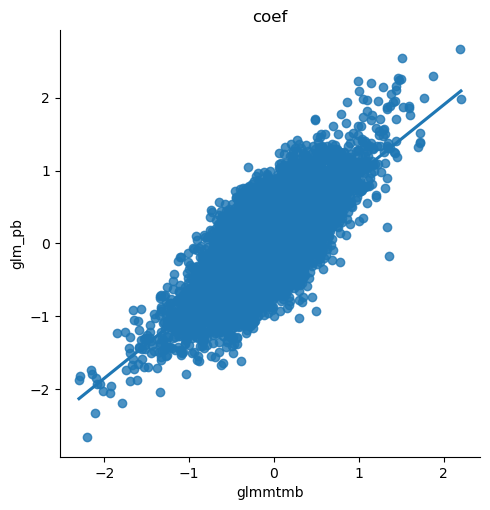

### glmmtmb vs diffexpy, pair count 363914


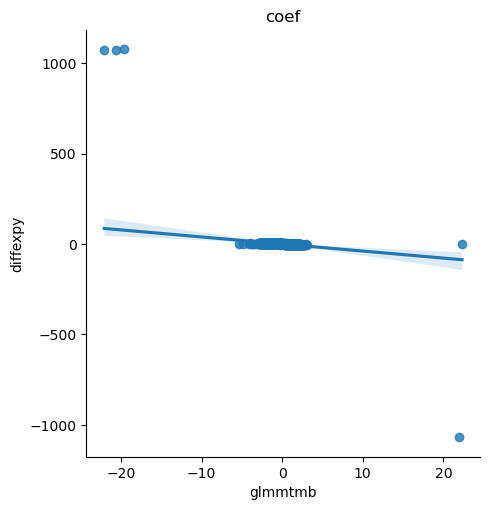

### glmmtmb vs glmm_nz, pair count 120943


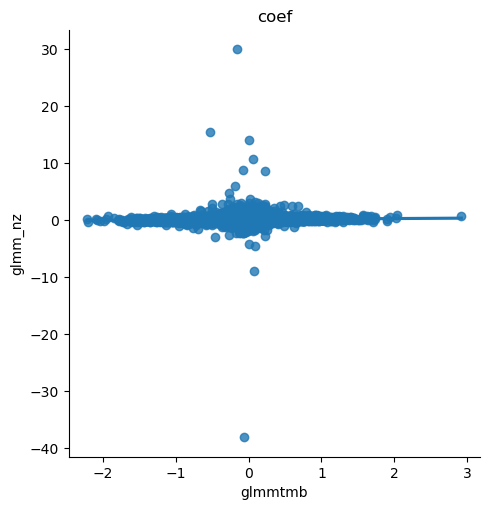

### glmmtmb vs glmm_zi, pair count 148542


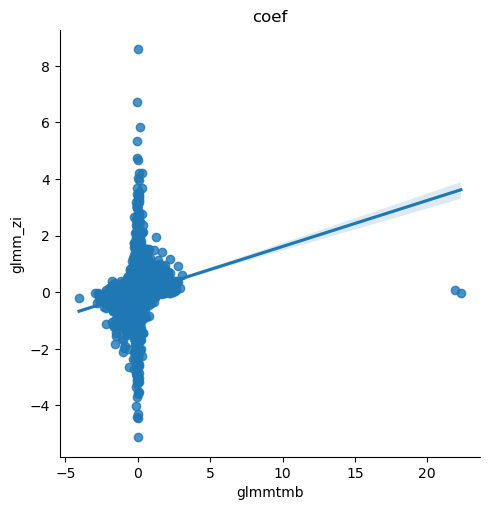

In [8]:
gs_method = 'glmmtmb'
other_methods = set(results_df['method']) - set([gs_method])
for other_method in other_methods:
    print(f'### {gs_method} vs {other_method}', end=', ')
    these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                              other_method])]
    this_piv = these_results.pivot_table(values=METRIC_TO_USE, index=['feature', 'tissue'], 
                                         columns='method')
    # this_piv = this_piv.fillna(0)
    this_piv = this_piv.dropna()    
    this_piv = this_piv.replace([inf, -inf], 0)
    print(f'pair count {this_piv.shape[0]}')
#     display(this_piv.head())
    with rc_context({'figure.figsize': (9, 9)}):
        # plt.style.use('seaborn-talk') 
        lmplot(data=this_piv, x=gs_method, y=other_method)
        plt.title(METRIC_TO_USE)
        plt.show()

#### visualize glmm_zi and glm_pb

### glmm_zi vs glm_pb


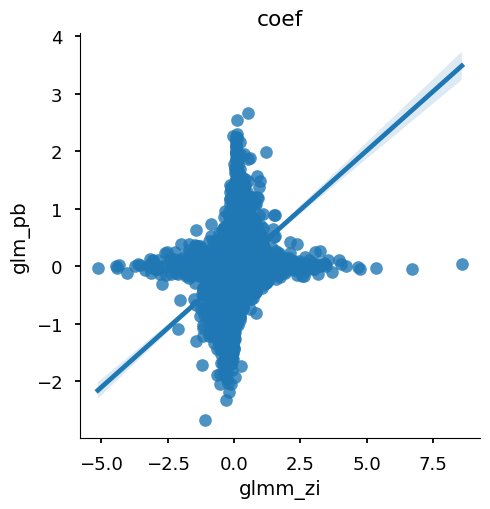

In [9]:
gs_method = 'glmm_zi'
other_method = 'glm_pb'
print(f'### {gs_method} vs {other_method}')
these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                          other_method])]
this_piv = these_results.pivot_table(values=METRIC_TO_USE, index=['feature', 'tissue'], 
                                     columns='method')
this_piv = this_piv.dropna()    
this_piv = this_piv.replace([inf, -inf], 0)
with rc_context({'figure.figsize': (9, 9)}):
    plt.style.use('seaborn-talk') 
    lmplot(data=this_piv, x=gs_method, y=other_method)
    plt.title(METRIC_TO_USE)
    plt.show()

### check scoring metrics

In [10]:
gs_method = 'glmmtmb'
other_methods = set(results_df['method']) - set([gs_method])
for other_method in other_methods:
    print(f'### {gs_method} vs {other_method}')
    these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                              other_method])]
    this_piv = these_results.pivot_table(values=METRIC_TO_USE, index=['feature', 'tissue'], 
                                         columns='method')
    # this_piv = this_piv.fillna(0)
    this_piv = this_piv.dropna()    
    this_piv = this_piv.replace([inf, -inf], 0)
    r2 = r2_score(this_piv[gs_method], this_piv[other_method])
    mape = mean_absolute_percentage_error(this_piv[gs_method], this_piv[other_method])
    mae = mean_absolute_error(this_piv[gs_method], this_piv[other_method])
    rmse = sqrt(mean_squared_error(this_piv[gs_method], this_piv[other_method]))
    print(f'\tr2 score is {r2}')
    print(f'\tMAPE score is {mape}')
    print(f'\tMAE score is {mae}')
    print(f'\tRMSE score is {rmse}')

### glmmtmb vs glm_pb
	r2 score is 0.11743498081986425
	MAPE score is 4.796198602649937
	MAE score is 0.14277839098018436
	RMSE score is 0.2038787866648475
### glmmtmb vs diffexpy
	r2 score is -135.84200895837623
	MAPE score is 7.599309316142582
	MAE score is 0.639285087509581
	RMSE score is 3.7245533622133618
### glmmtmb vs glmm_nz
	r2 score is -0.8642956726108828
	MAPE score is 3.8154472839897924
	MAE score is 0.22758874074279506
	RMSE score is 0.3480749536074116
### glmmtmb vs glmm_zi
	r2 score is -0.02412116747634907
	MAPE score is 2.2717281320427705
	MAE score is 0.1980624875240718
	RMSE score is 0.3287268876253523


### model similarities with linear regression

In [11]:
gs_method = 'glmmtmb'
other_methods = set(results_df['method']) - set([gs_method])
for other_method in other_methods:
    print(f'### {gs_method} ~ {other_method}')
    these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                              other_method])]
    this_piv = these_results.pivot_table(values=METRIC_TO_USE, index=['feature', 'tissue'], 
                                         columns='method')
    # this_piv = this_piv.fillna(0)
    this_piv = this_piv.dropna()
    this_piv = this_piv.replace([inf, -inf], 0)
    model_results = ols(formula=f'{gs_method} ~ {other_method}', 
                        data=this_piv).fit()
    print(model_results.summary())    

### glmmtmb ~ glm_pb
                            OLS Regression Results                            
Dep. Variable:                glmmtmb   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                 1.186e+05
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:20:17   Log-Likelihood:                 53453.
No. Observations:              115906   AIC:                        -1.069e+05
Df Residuals:                  115904   BIC:                        -1.069e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0564      0.00

In [12]:
gs_method = 'glmm_zi'
other_method = 'glm_pb'
print(f'### {gs_method} ~ {other_method}')
these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                          other_method])]
this_piv = these_results.pivot_table(values=METRIC_TO_USE, index=['feature', 'tissue'], 
                                     columns='method')
# this_piv = this_piv.fillna(0)
this_piv = this_piv.dropna()
this_piv = this_piv.replace([inf, -inf], 0)
model_results = ols(formula=f'{gs_method} ~ {other_method}', 
                    data=this_piv).fit()
print(model_results.summary()) 

### glmm_zi ~ glm_pb
                            OLS Regression Results                            
Dep. Variable:                glmm_zi   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     9088.
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:20:20   Log-Likelihood:                 31829.
No. Observations:              113319   AIC:                        -6.365e+04
Df Residuals:                  113317   BIC:                        -6.363e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0272      0.00

### visualize using Upsets

#### format the data

In [17]:
results_df.head()

,feature,coef,score,p-value,tissue,type,fdr_bh,method
0,AL627309.1,0.216203,1.116001,0.264422,ExN,broad_celltype,0.411736,glmmtmb
1,AL627309.5,0.135696,1.892662,0.058403,ExN,broad_celltype,0.169697,glmmtmb
2,LINC01409,0.001862,0.053097,0.957655,ExN,broad_celltype,0.991086,glmmtmb
3,LINC01128,0.030509,0.990535,0.321913,ExN,broad_celltype,0.468546,glmmtmb
4,LINC00115,0.057234,0.405254,0.685291,ExN,broad_celltype,0.787400,glmmtmb


In [20]:
# get all significant results
these_results = results_df.loc[(results_df.fdr_bh <= 0.05) & (results_df.method != 'diffexpy')]
# reformat
this_piv = these_results.pivot_table(values=METRIC_TO_USE, index=['feature', 'tissue'], 
                                     columns='method')
# set call values
for col in this_piv.columns:
    this_piv[col] = where(this_piv[col].isna(), False, True)
if DEBUG:
    display(these_results.sample(5))
    display(this_piv.sample(5))

,feature,coef,score,p-value,tissue,type,fdr_bh,method
323249,AL096870.8,-0.640967,-3.348759,8.117448e-04,ExN FEZF2,specific_celltype,1.781547e-02,glmmtmb
40501,CPB2,-0.412946,-3.141713,1.679623e-03,InN,broad_celltype,2.700659e-02,glmmtmb
44738,ATP5PF,-0.279451,-3.540058,4.000392e-04,InN,broad_celltype,1.179337e-02,glmmtmb
196459,C22orf34,1.313750,6.520002,7.030658e-11,Entorhinal cortex Microglia,region_broad_celltype,9.897044e-08,glmmtmb
416561,USP15,-0.297822,-4.289950,1.787131e-05,Entorhinal cortex_Endothelial,region_broad_celltype,1.252240e-02,glm_pb


,method,glm_pb,glmm_nz,glmm_zi,glmmtmb
feature,tissue,,,,
SDC2,ExN CUX2 LAMP5,False,False,False,True
AC034195.1,SPN D1-2,False,False,False,True
PDZD8,Entorhinal cortex Astrocyte,False,False,False,True
LINC01141,Subventricular zone Microglia,False,False,False,True
OR10G4,Middle temporal gyrus ExN,False,False,False,True


#### show the Upset

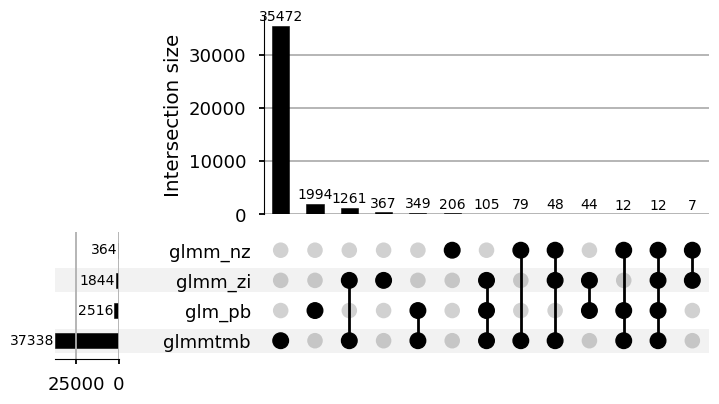

In [21]:
with rc_context({'figure.figsize': (12, 12)}):
    plt.style.use('seaborn-talk') 
    upset_plot(this_piv.groupby(this_piv.columns.to_list()).size(), 
         sort_by='cardinality', show_counts=True)
    plt.show()

In [15]:
!date

Thu Jan 18 12:20:21 EST 2024
